In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys, os

data = ['CA','GB','US']

sys.path.insert(0, os.path.abspath('../submitted'))
from scripts import project_functions # This is called a relative import
df_lastdate = project_functions.load_and_process(data)

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [3]:
df_lastdate.profile_report()

# analysis

In [4]:
tagRatios = {}
for index, row in df_lastdate.iterrows():
    if row["ratio"]==0:
        continue
    for i in row["tags"]:
        if i in tagRatios:
            tagRatios[i][0]+=row["likes"]
            tagRatios[i][1]+=row["dislikes"]
        else:
            tagRatios[i] = [row["likes"],row["dislikes"]]
for i in tagRatios:
    tagRatios[i] = tagRatios[i][0]/tagRatios[i][1]
#print(tagRatios)

In [5]:
#print([(i, tagRatios[i]) for i in {k: v for k, v in sorted(tagRatios.items(), key=lambda item: item[1])}])

# currently commented because it takes up such a large amount of space
# ordered list of tags by like/dislike ratio
# people like kpop and dislike bon appetit

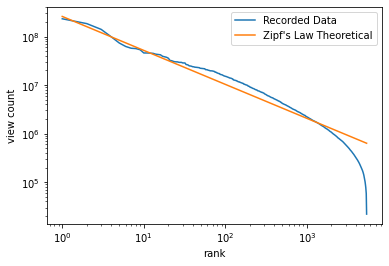

In [6]:
s=0.7
denom = sum([1/i**s for i in range(1,1+len(df_lastdate["view_count"].tolist()))])
plt.loglog(range(1,1+len(df_lastdate["view_count"].tolist())), sorted(df_lastdate["view_count"].tolist())[::-1])
plt.loglog(range(1,1+len(df_lastdate["view_count"].tolist())),[sum(df_lastdate["view_count"].tolist())*((1/k**s)/denom) for k in range(1,1+len(df_lastdate["view_count"].tolist()))])
plt.ylabel('view count')
plt.xlabel('rank')
plt.legend(['Recorded Data',"Zipf's Law Theoretical"])

view count appears to follow [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

In [7]:
tagfreq = {}
for index, row in df_lastdate.iterrows():
    for i in row["tags"]:
        if i in tagfreq:
            tagfreq[i] += row["view_count"]
        else:
            tagfreq[i] = row["view_count"]
#print(tagfreq)

In [31]:
#top 20 tags (not counting no tags)
print([(i, tagfreq[i]) for i in {k: v for k, v in sorted(tagfreq.items(), key=lambda item: item[1])}][-2:-22:-1])

[('BTS', 623706002), ('BLACKPINK', 585010211), ('블랙핑크', 575831191), ('YG', 569182590), ('와이지', 568699653), ('지수', 568240294), ('리사', 568240294), ('로제', 568240294), ('제니', 568240294), ('K-pop', 566729151), ('YG Entertainment', 566729151), ('Rosé', 527347987), ('Jennie', 527347987), ('Jisoo', 527347987), ('Lisa', 527347987), ('블핑', 527024739), ('블링크', 524162349), ('BLINK', 522191847), ('방탄소년단', 480830570), ('BANGTAN', 459132651)]


In [9]:
# this is the old loading and cleaning of the dataset
# the current function removes duplicate videos which is optimal most of the time 
# but I have a graph below which is only meaningful with duplicate videos

df = pd.concat([pd.read_csv('../../data/raw/CA_youtube_trending_data.csv'),pd.read_csv('../../data/raw/GB_youtube_trending_data.csv'),pd.read_csv('../../data/raw/US_youtube_trending_data.csv')])
df["trending_date"] = df.apply(lambda row: pd.to_datetime(row["trending_date"]), axis=1)
df["publishedAt"] = df.apply(lambda row: pd.to_datetime(row["publishedAt"]), axis=1)
category_replace = {
      1:'Film & Animation',
      2:'Autos & Vehicles',
      10:'Music',
      15:'Pets & Animals',
      17:'Sports',
      19:'Travel & Events', 
      20:'Gaming',
      21:'Videoblogging',
      22: "People & Blogs",
      23: "Comedy", 
      24: "Entertainment",
      25: "News & Politics", 
      26: "Howto & Style", 
      27: "Education", 
      28: "Science & Technology",
      29: 'NaN'
    }
df_clean = df.drop(columns = ['thumbnail_link','comments_disabled','ratings_disabled','channelId'])
df_clean = df_clean.replace({"categoryId":category_replace}).rename(columns= {'categoryId':'category'})
df_clean = df_clean.drop(df_clean[df_clean['category']=='NaN'].index).sort_values('trending_date')
df_clean = df_clean[df_clean['likes'] != 0]
df_clean = df_clean.reset_index().drop(columns = ['index'])
#turn tags into actual list
df_clean["tags"] = df_clean.apply(lambda row: row["tags"].split("|"), axis=1)
#calculate the videos' like to dislike ratio (assuming that there are likes and dislikes)
df_clean["ratio"] = df_clean.apply(lambda row: 0 if row["dislikes"]==0 else (row["likes"]/row["dislikes"]), axis=1)
df_clean["log_views"] = df_clean.apply(lambda row: 0 if row["view_count"]==0 else np.log(row["view_count"]), axis=1)

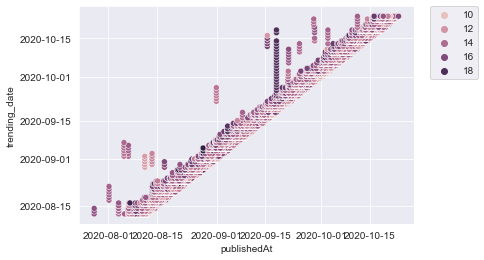

In [10]:
sns.set_style("darkgrid")
sns.scatterplot(x="publishedAt", y="trending_date", data = df_clean, hue = "log_views")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

videos tend to trend around the same time they're uploaded<br>
I was expecting the outliers to have unusually high view counts to explain their staying power however that doesn't seem to be the case

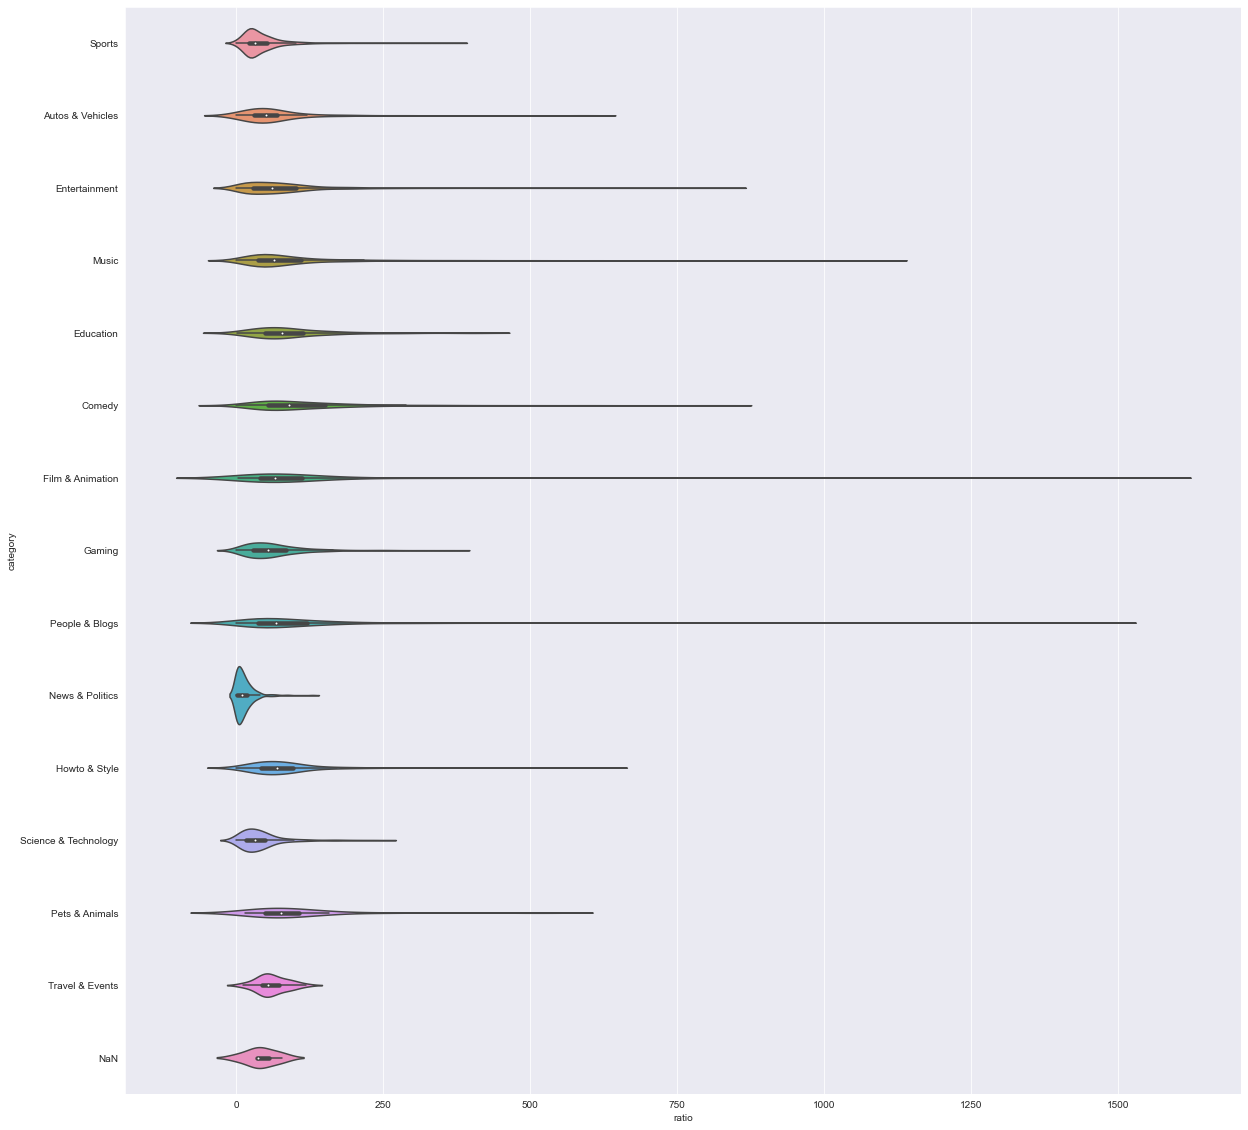

In [11]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
sns.violinplot(x = "ratio", y = "category", data = df_lastdate)

like-dislike ratio charts by category<br>
*News & Politics* is the clear loser here<br>
There are a lot of outliers, probably due to using a ratio as the x axis

0.010418063923869812


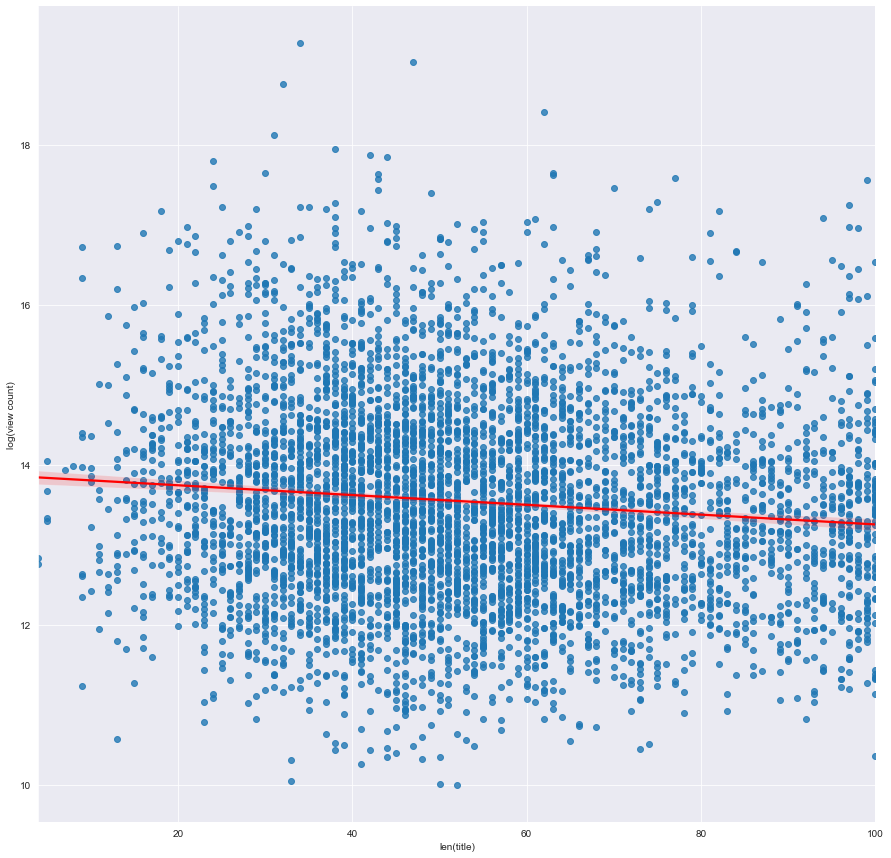

In [21]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
sns.regplot(x=df_lastdate.apply(lambda row: len(row["title"]), axis=1),y=df_lastdate.apply(lambda row: np.log(row["view_count"]), axis=1), line_kws={"color": "red"})
sns.despine(right = True)
plt.ylabel('log(view count)')
plt.xlabel('len(title)')

print(np.corrcoef(df_lastdate.apply(lambda row: len(row["title"]), axis=1), df_lastdate.apply(lambda row: np.log(row["view_count"]), axis=1))[0,1]**2)

the $r^{2}$ value for the log of view count vs length of title is 0.0104<br>
there is no correlation between title length and view count

0.008699386361787801


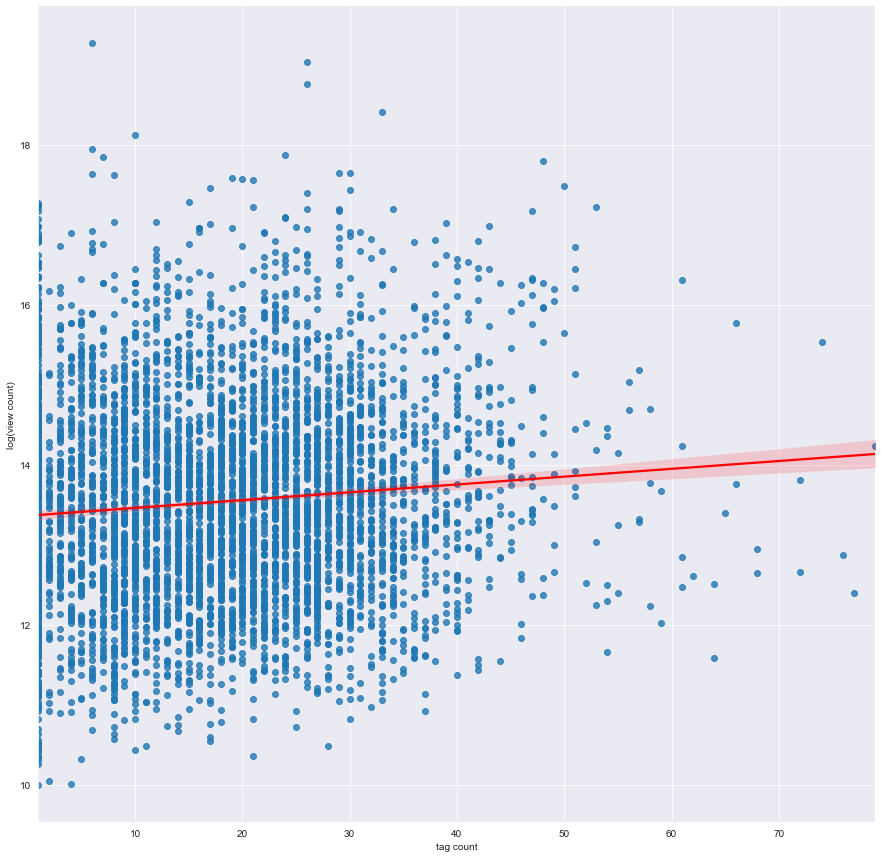

In [22]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
sns.regplot(x=df_lastdate.apply(lambda row: len(row["tags"]), axis=1),y=df_lastdate.apply(lambda row: np.log(row["view_count"]), axis=1), line_kws={"color": "red"})
sns.despine(right = True)
plt.ylabel('log(view count)')
plt.xlabel('tag count')

print(np.corrcoef(df_lastdate.apply(lambda row: len(row["tags"]), axis=1), df_lastdate.apply(lambda row: np.log(row["view_count"]), axis=1))[0,1]**2)

the $r^{2}$ value for the log of view count vs number of tags is 0.0087<br>
there is no correlation between tag count and view count